In [1]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
from gan_mnist_ops import generator, discriminator

In [3]:
mnist_data = input_data.read_data_sets('MNIST_data/')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(1, 784)


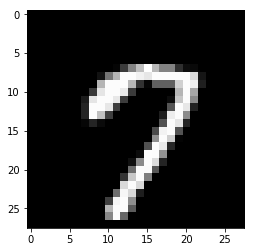

In [4]:
sample_image = mnist_data.train.next_batch(1)[0]
print(sample_image.shape)
sample_image = sample_image.reshape([28,28])
plt.imshow(sample_image, cmap='gray')

## Sample Image Generating

In [5]:
z_dimensions = 100 
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [6]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

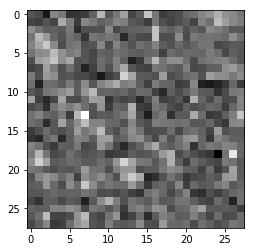

In [7]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output, feed_dict={z_placeholder:z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='gray')

## Training GAN with MNIST

In [8]:
tf.reset_default_graph()
batch_size = 50

# z_placeholder is for feeding input noise to the "generator"
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder')
# x_placeholder is for feeding input images to the "discriminator"
x_placeholder = tf.placeholder(tf.float32, [None, 28, 28, 1], name='x_placeholder')

# Gz holds the generated images
Gz = generator(z_placeholder, batch_size, z_dimensions)

# Dx will hold discriminator prediction probabilities
# for the real MNIST images
Dx_prob, Dx_logit = discriminator(x_placeholder)

# Dg will hold discriminator prediction probabilities for generated images
Dg_prob, Dg_logit = discriminator(Gz, reuse=True)

### Define Discriminator Loss Function

In [9]:
# Compare real images loss probabilities : 1 <-> Dx output
# tf.ones_like : Make same shape of 1 matrix
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx_logit, labels=tf.ones_like(Dx_logit)))

# Compare fake images loss probabilities : 0 <-> Dg outut
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg_logit, labels=tf.zeros_like(Dg_logit)))

d_loss = d_loss_fake + d_loss_real

### Define Generator Loss Function

In [10]:
# generator wants the discriminator to output a value close to 1 when it's given an image from the generator
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg_logit, labels=tf.ones_like(Dg_logit)))

### Figure out training variables

In [11]:
tvars = tf.trainable_variables()
d_tvars = [var for var in tvars if 'd_' in var.name]
g_tvars = [var for var in tvars if 'g_' in var.name]

print(d_tvars)
print(g_tvars)

[<tf.Variable 'd_w1:0' shape=(5, 5, 1, 32) dtype=float32_ref>, <tf.Variable 'd_b1:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'd_w2:0' shape=(5, 5, 32, 64) dtype=float32_ref>, <tf.Variable 'd_b2:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'd_w3:0' shape=(3136, 1024) dtype=float32_ref>, <tf.Variable 'd_b3:0' shape=(1024,) dtype=float32_ref>, <tf.Variable 'd_w4:0' shape=(1024, 1) dtype=float32_ref>, <tf.Variable 'd_b4:0' shape=(1,) dtype=float32_ref>]
[<tf.Variable 'g_w1:0' shape=(100, 3136) dtype=float32_ref>, <tf.Variable 'g_b1:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'g_w2:0' shape=(3, 3, 1, 50) dtype=float32_ref>, <tf.Variable 'g_b2:0' shape=(50,) dtype=float32_ref>, <tf.Variable 'g_w3:0' shape=(3, 3, 50, 25) dtype=float32_ref>, <tf.Variable 'g_b3:0' shape=(25,) dtype=float32_ref>, <tf.Variable 'g_w4:0' shape=(1, 1, 25, 1) dtype=float32_ref>, <tf.Variable 'g_b4:0' shape=(1,) dtype=float32_ref>]


### Apply Trainer

In [12]:
# Disciminator trainer
d_trainer = tf.train.AdamOptimizer(0.0003).minimize(d_loss, var_list=d_tvars)

# Generator trainer
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_tvars)

In [13]:
tf.get_variable_scope().reuse_variables()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_Image', images_for_tensorboard, 5)
merged = tf.summary.merge_all()

logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '/'
writer = tf.summary.FileWriter(logdir, sess.graph)

In [14]:
for i in range(300):
    z_batch = np.random.normal(0, 1, [batch_size, z_dimensions])
    real_image_batch = mnist_data.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, _, dLoss, gLoss  = sess.run([d_trainer, g_trainer, d_loss, g_loss], 
                                    feed_dict={z_placeholder:z_batch, x_placeholder:real_image_batch})
    if i % 100 == 0:
        print("Discriminator loss : {}, Generator loss : {}".format(dLoss, gLoss))

Discriminator loss : 1.3894093036651611, Generator loss : 0.6873776316642761
Discriminator loss : 9.922561730490997e-06, Generator loss : 12.127161026000977
Discriminator loss : 2.193010186601896e-05, Generator loss : 11.473627090454102


In [15]:
saver = tf.train.Saver()

### Train generator and discriminator together

i : 0, at : 2017-09-12 16:58:53.094512


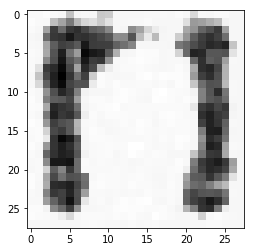

Estimated result : [[  1.58390903e-05]]
i : 1000, at : 2017-09-12 17:00:41.962882


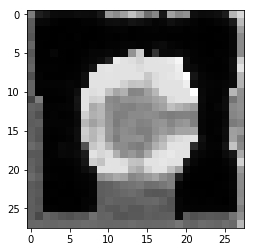

Estimated result : [[ 0.00118826]]
i : 2000, at : 2017-09-12 17:02:30.369559


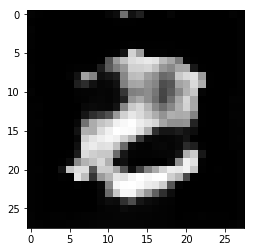

Estimated result : [[ 0.00115635]]
i : 3000, at : 2017-09-12 17:04:18.977686


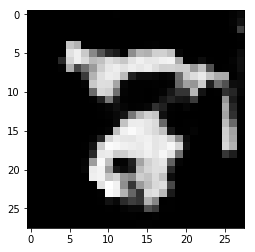

Estimated result : [[ 0.00041978]]
i : 4000, at : 2017-09-12 17:06:07.606405


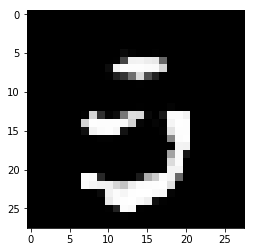

Estimated result : [[ 0.50288141]]
i : 5000, at : 2017-09-12 17:07:56.186025


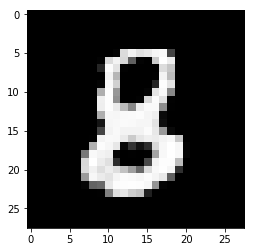

Estimated result : [[ 0.08832113]]
i : 6000, at : 2017-09-12 17:09:44.688945


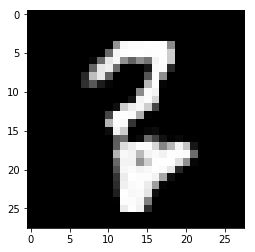

Estimated result : [[ 0.04372929]]
i : 7000, at : 2017-09-12 17:11:33.226528


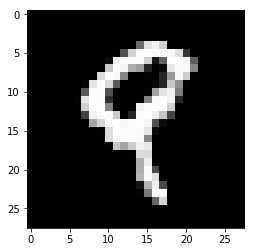

Estimated result : [[ 0.00638718]]
i : 8000, at : 2017-09-12 17:12:58.876237


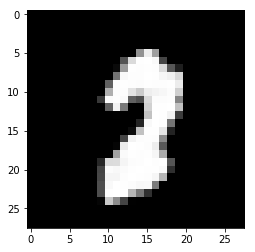

Estimated result : [[ 0.03493313]]
i : 9000, at : 2017-09-12 17:13:43.463338


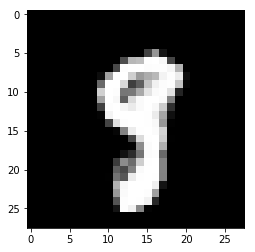

Estimated result : [[ 0.0139288]]
i : 10000, at : 2017-09-12 17:14:27.994687


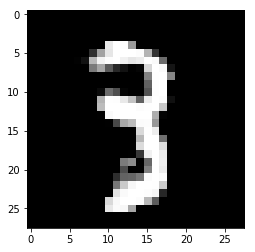

Estimated result : [[ 0.03592912]]
i : 11000, at : 2017-09-12 17:15:12.741933


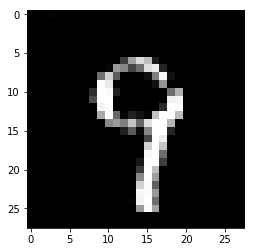

Estimated result : [[ 0.00476291]]
i : 12000, at : 2017-09-12 17:15:57.062919


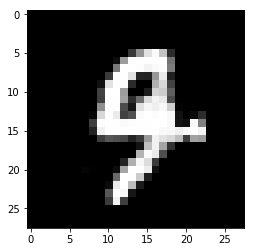

Estimated result : [[ 0.02809027]]
i : 13000, at : 2017-09-12 17:16:41.208636


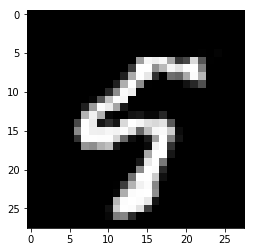

Estimated result : [[ 0.12443805]]
i : 14000, at : 2017-09-12 17:17:25.859215


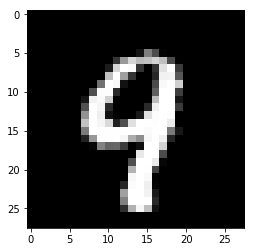

Estimated result : [[ 0.1886027]]
i : 15000, at : 2017-09-12 17:18:10.225524


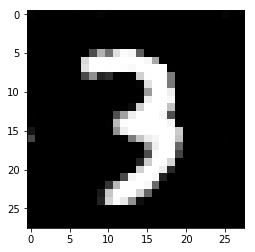

Estimated result : [[ 0.00688296]]
i : 16000, at : 2017-09-12 17:18:54.649100


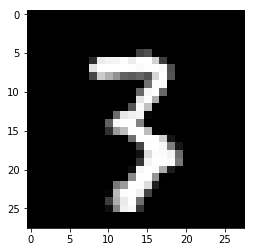

Estimated result : [[ 0.0120313]]
i : 17000, at : 2017-09-12 17:19:39.083290


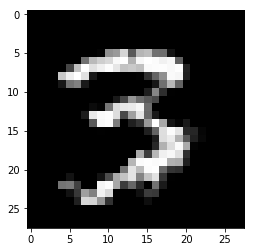

Estimated result : [[ 0.00193237]]
i : 18000, at : 2017-09-12 17:20:23.605131


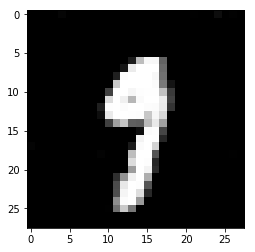

Estimated result : [[ 0.01116043]]
i : 19000, at : 2017-09-12 17:21:08.210225


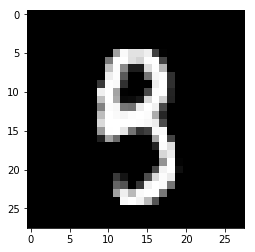

Estimated result : [[ 0.00810928]]
i : 20000, at : 2017-09-12 17:21:52.849756


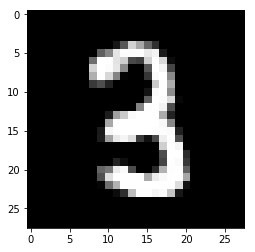

Estimated result : [[ 0.04040496]]
i : 21000, at : 2017-09-12 17:22:37.651389


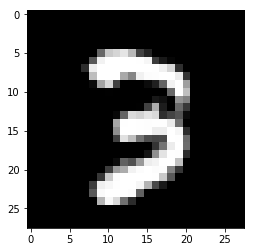

Estimated result : [[ 0.05837419]]
i : 22000, at : 2017-09-12 17:23:22.095368


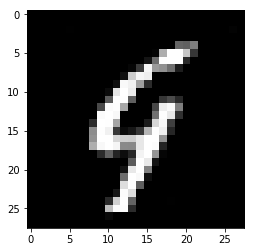

Estimated result : [[ 0.00702541]]
i : 23000, at : 2017-09-12 17:24:06.576649


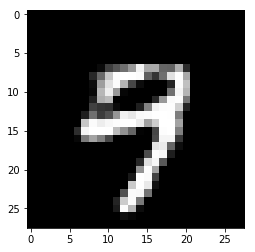

Estimated result : [[ 0.02820825]]
i : 24000, at : 2017-09-12 17:24:51.056003


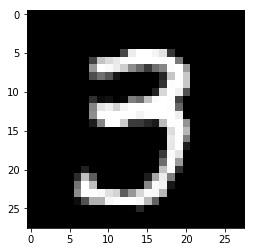

Estimated result : [[ 0.17567769]]
i : 25000, at : 2017-09-12 17:25:35.451691


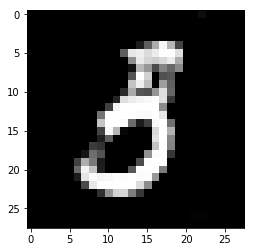

Estimated result : [[ 0.01023855]]
i : 26000, at : 2017-09-12 17:26:19.868618


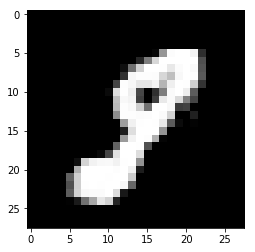

Estimated result : [[ 0.00908999]]
i : 27000, at : 2017-09-12 17:27:04.389428


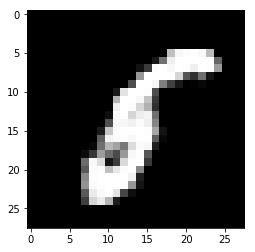

Estimated result : [[ 0.80920112]]
i : 28000, at : 2017-09-12 17:27:48.927466


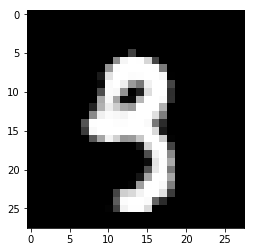

Estimated result : [[ 0.00408134]]
i : 29000, at : 2017-09-12 17:28:33.389457


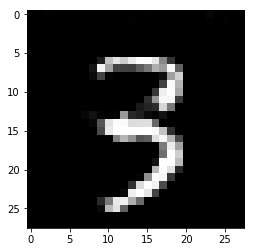

Estimated result : [[ 0.01479776]]
i : 30000, at : 2017-09-12 17:29:17.865190


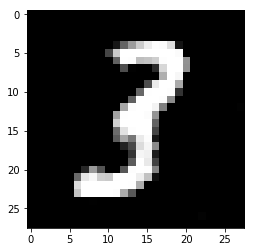

Estimated result : [[ 0.01384766]]
i : 31000, at : 2017-09-12 17:30:02.766612


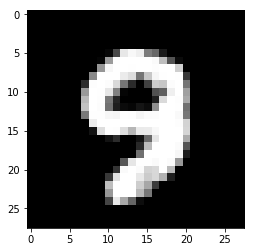

Estimated result : [[ 0.00550163]]
i : 32000, at : 2017-09-12 17:30:47.157691


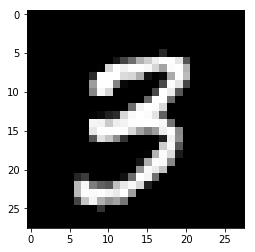

Estimated result : [[ 0.01187757]]
i : 33000, at : 2017-09-12 17:31:31.631509


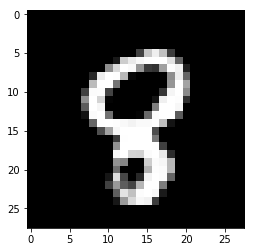

Estimated result : [[ 0.01923087]]


KeyboardInterrupt: 

In [16]:
for i in range(100000):
    # train discriminator
    z_batch = np.random.normal(0, 1, [batch_size, z_dimensions])
    real_image_batch = mnist_data.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, _, dLoss, gLoss = sess.run([d_trainer, g_trainer, d_loss, g_loss], 
                                          feed_dict={x_placeholder:real_image_batch, z_placeholder:z_batch})

    # train generator
    z_batch = np.random.normal(0, 1, [batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder:z_batch})

    if i % 10 == 0:
        # Update tensorboard
        z_batch = np.random.normal(0, 1, [batch_size, z_dimensions])
        summary = sess.run(merged, feed_dict={z_placeholder:z_batch, x_placeholder:real_image_batch})
        writer.add_summary(summary, i)

    if i % 1000 == 0:
        # Every 100 iters, show generated images
        print("i : {}, at : {}".format(i, datetime.datetime.now()))
        z_batch = np.random.normal(0, 1, [1, z_dimensions])
        generating_image_tensor = generator(z_placeholder, 1, z_dimensions)
        generated_image = sess.run(generating_image_tensor, feed_dict={z_placeholder:z_batch})
        plt.imshow(generated_image[0].reshape([28,28]), cmap='gray')
        plt.show()

        # Show discriminator's estimate
        im = generated_image[0].reshape([1, 28, 28, 1])
        discriminator_result_tensor, _ = discriminator(x_placeholder)
        estimate_result = sess.run(discriminator_result_tensor, feed_dict={x_placeholder:im})
        print("Estimated result : {}".format(estimate_result))

    if i % 10000 == 0:
        # Save weights
        saver.save(sess, 'pretrained-model/lossum_gan.ckpt', global_step=i)

## After training, we can load weights by restore

In [18]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, 'pretrained-model/pretrained_gan.ckpt')
    z_batch = np.random.normal(0, 1, [10, z_dimensions])
    z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder')
    generated_images = generator(z_placeholder, 10, z_dimensions)
    images = sess.run(generated_images, feed_dict={z_placeholder:z_batch})
    for i in range(10):
        plt.imshow(images[i].reshpae([28, 28]), cmap='gray')
        plt.show()

INFO:tensorflow:Restoring parameters from pretrained-model/pretrained_gan.ckpt


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for pretrained-model/pretrained_gan.ckpt
	 [[Node: save/RestoreV2_21 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_21/tensor_names, save/RestoreV2_21/shape_and_slices)]]
	 [[Node: save/RestoreV2_12/_133 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_294_save/RestoreV2_12", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'save/RestoreV2_21', defined at:
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-a2b1622e5f8f>", line 1, in <module>
    saver = tf.train.Saver()
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1139, in __init__
    self.build()
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1170, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 640, in restore_v2
    dtypes=dtypes, name=name)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/soma/anaconda3/envs/venvOpenCV3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for pretrained-model/pretrained_gan.ckpt
	 [[Node: save/RestoreV2_21 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_21/tensor_names, save/RestoreV2_21/shape_and_slices)]]
	 [[Node: save/RestoreV2_12/_133 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_294_save/RestoreV2_12", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
